In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("news_with_risk_score.csv")

df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)

In [4]:
def round_to_half_hour(dt):
    # If minutes < 30 → set to previous half-hour (hh:30 of previous hour)
    # If minutes >= 30 → set to hh:30 of current hour
    return dt.replace(minute=30, second=0, microsecond=0) if dt.minute >= 30 else (dt - pd.Timedelta(hours=1)).replace(minute=30, second=0, microsecond=0)

In [5]:
df['hour'] = df['datetime'].apply(round_to_half_hour)

In [6]:
pivot = df.pivot_table(index='hour',
                       columns='source',
                       values='risk score',
                       aggfunc='mean',  
                       fill_value=0)

In [7]:
pivot = pivot.reset_index()
pivot.head()

source,hour,News,Reddit
0,2025-03-15 17:30:00,0.0,4.5
1,2025-03-16 12:30:00,0.0,4.0
2,2025-03-17 19:30:00,0.0,3.0
3,2025-03-17 23:30:00,0.0,3.0
4,2025-03-18 18:30:00,0.0,4.0


In [8]:
# Function to aggregate scores per hour
def aggregate_scores(row, weights):
    w_news, w_reddit = weights
    news_score = row.get('News', 0)
    reddit_score = row.get('Reddit', 0)
    numerator = w_news * news_score + w_reddit * reddit_score
    denominator = w_news + w_reddit
    return numerator / denominator if denominator != 0 else 0


# Function to compute clustering quality
def clustering_quality(aggregated_scores, n_clusters=5):
    y = np.array(aggregated_scores).reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(y)
    labels = kmeans.labels_
    score = silhouette_score(y, labels)
    return score

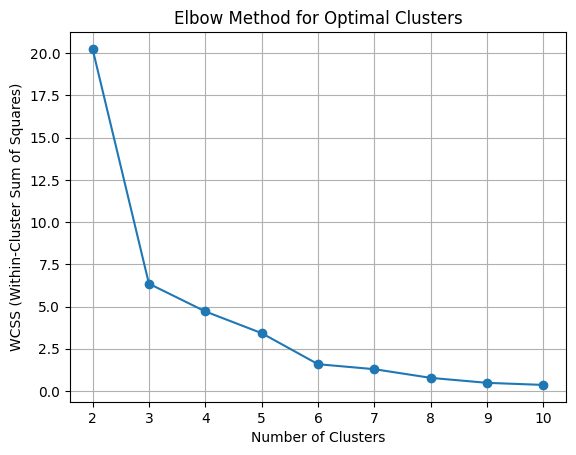

In [ ]:
# Random initial weights
initial_weights = [0.5, 0.5]    # weight_news, weight_reddit

# Aggregated risk scores (1D array)
aggregated_scores = pivot.apply(lambda row: aggregate_scores(row, initial_weights), axis=1)

cluster_range = range(2, 11)
wcss = []

# Calculate WCSS for each value of n_clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(aggregated_scores.values.reshape(-1, 1))  
    wcss.append(kmeans.inertia_)  

# Plot the Elbow Method (WCSS vs. Number of Clusters)
plt.plot(cluster_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal Clusters')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

Based on the elbow method, n_clusters=5 is chosen.

### Plot the clusters

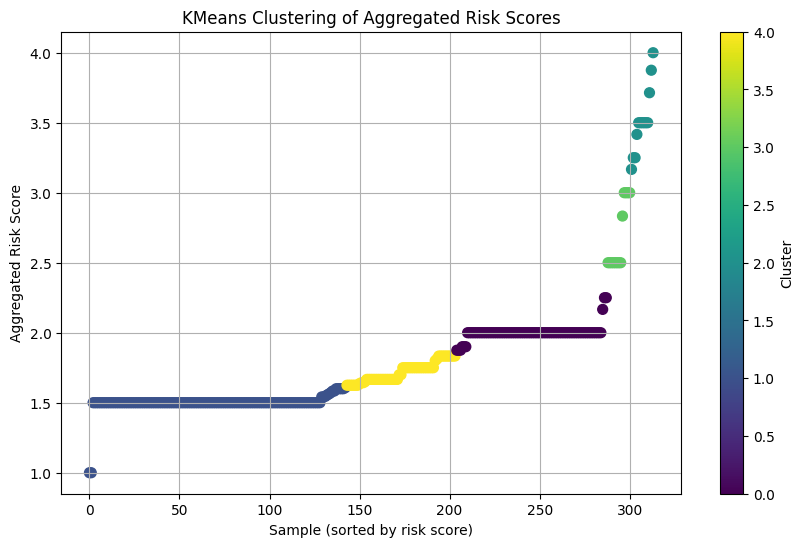

In [15]:
# Prepare for clustering
X = np.array(aggregated_scores).reshape(-1, 1)

# Run KMeans
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10)
labels = kmeans.fit_predict(X)

# Sort by risk score for better visual
sorted_idx = np.argsort(X[:, 0])
X_sorted = X[sorted_idx]
labels_sorted = np.array(labels)[sorted_idx]

plt.figure(figsize=(10, 6))

# Scatter plot: risk score vs cluster
plt.scatter(range(len(X_sorted)), X_sorted[:, 0], c=labels_sorted, cmap='viridis', s=50)

plt.title('KMeans Clustering of Aggregated Risk Scores')
plt.xlabel('Sample (sorted by risk score)')
plt.ylabel('Aggregated Risk Score')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

### Optimize the weights

In [12]:
from scipy.optimize import minimize

# Loss function to minimize (negative silhouette score)
def loss(weights, data):
    # Avoid zero or negative weights
    weights = np.clip(weights, 1e-3, None)
    
    # Aggregate scores
    aggregated_scores = data.apply(lambda row: aggregate_scores(row, weights), axis=1)
    
    # Compute negative clustering quality
    return -clustering_quality(aggregated_scores, n_clusters=5)

def constraint(weights):
    # Constraint the sum of weight_news + weight_reddit = 1
    return np.sum(weights) - 1

# Initial guess for weights
initial_weights = [0.5, 0.5]  # [w_news, w_reddit]

# Define the bounds for each weight: they should stay between 0 and 1
bounds = [(0.001, 1), (0.001, 1)]  # weights must be in the range [0, 1]

# Define the constraint dictionary
constr = {'type': 'eq', 'fun': constraint}  # 'eq' means equality constraint

# Run the optimizer with the constraint
result = minimize(loss, initial_weights, args=(pivot,), bounds=bounds, constraints=constr)
optimal_weights = result.x

print(f"Optimal weights: news={optimal_weights[0]:.4f}, reddit={optimal_weights[1]:.4f}")

Optimal weights: news=0.5707, reddit=0.4293
